<center>
    <h3>Modelos Descriptivos y Predictivos II - Grado en Ciencia de Datos</h3>
    <h3>Universitat Politècnica de València</h3>
    <h1>Práctica 4: Máquinas de Soporte Vectorial (SVM)</h1>
    <h2>Sesión 1</h2>
</center>

### Objetivos formativos:

- Entender los conceptos fundamentales del clasificador SVM
- Analizar distintas tareas creadas artificialmente mediante datasets sintéticos.
- Evaluar el efecto de distintos kernels en distintas tareas
- Evaluar el efecto de los parámetros C y gamma
- Encontrar los hiperpará,metros óptimos para una tarea determinada

### Importación de módulos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons, make_blobs, make_circles, load_wine, load_breast_cancer
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

### Creación de datasets artificiales

En esta práctica usaremos algunos conjuntos de datos creados de manera artificial. A continuación se da el código de distintas funciones para crear estos datasets:
- `create_dataset_linear`: genera puntos n-dimensionales en dos grupos (blobs) con centroides en (-1,-1,...,-1) y (1,1,...,1).<br>**Parámetros:**
    - `samples`: número de puntos a generar.
    - `std`: dispersión (desviación estándar) de los puntos en cada grupo. Puede ser un `float` (todos los grupos tienen la misma dispersión) o un array (permite especificar una dispersión distinta para cada grupo).
    - `n_features`: dimensión de los puntos generados.
- `create_dataset_moons`: genera puntos 2D en dos grupos con formas de media luna.<br>**Parámetros:**
    - `samples`: número de puntos a generar.
    - `noise`: ruido de las muestras. A mayor ruido, mayor solapamiento entre las muestras de ambos grupos.

- `create_dataset_poly`: genera puntos 2D en dos grupos separados por una frontera poligonal<br>**Parámetros:**
    - `coefs`: coeficientes del polígono que define la frontera.
    - `samples`: número de puntos a generar.
    - `noise`: ruido de las muestras. A mayor ruido, mayor solapamiento entre las muestras de ambos grupos.
    - `box`: tamaño del cuadrado en el que se enmarcan los puntos.


**Funciones generadoras de datos**

In [2]:
def create_dataset_linear(samples=300, std=0.5, n_features=2): 
    # Generar un conjunto de datos linealmente separable
    X, y = make_blobs(n_samples=samples, centers=[[-1]*n_features, [1]*n_features] , n_features=n_features, cluster_std=std, random_state=17)
    return X, y

def create_dataset_moons(samples=300, noise=0.1):
    # Generar un conjunto de datos con clases en forma de dos lunas
    X, y = make_moons(n_samples=samples, noise=noise, random_state=32)
    return X, y

def create_dataset_poly(coefs, samples=300, noise=0.1, box=20):
    np.random.seed(32)
    X = np.random.uniform(-box/2, box/2, (samples, 2))
    y = np.zeros(samples)
    grade = len(coefs)-1
    for i, p in enumerate(X):
        px,py = p[0],p[1]
        y_poly = sum(coef * (px ** (grade-j)) for j, coef in enumerate(coefs))
        y_noisy = y_poly + np.random.uniform(-noise, noise)*box
        y[i] = 0 if y_noisy < py else 1
    return X, y

**Crear datasets y plotear**

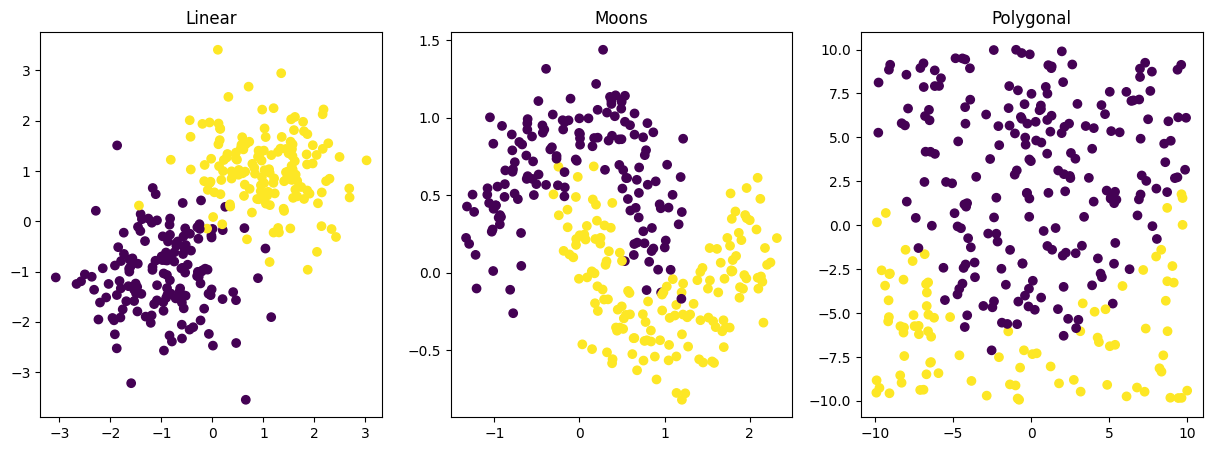

In [3]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

X, y = create_dataset_linear(std=[0.75,0.75])
ax[0].scatter(X[:, 0], X[:, 1], c=y)
ax[0].set_title('Linear')

X, y = create_dataset_moons(noise=0.2)
ax[1].scatter(X[:, 0], X[:, 1], c=y)
ax[1].set_title('Moons')

X, y = create_dataset_poly([0.1,0,-7], noise=0.1)
ax[2].scatter(X[:, 0], X[:, 1], c=y)
ax[2].set_title('Polygonal')

plt.show()

### Ejercicio 1. Separación de clases: fronteras de decisión, margen, vectores soporte y kernel 

El **margen** es la distancia entre el hiperplano de separación y los puntos de datos más cercanos de cada clase. El objetivo de SVM es maximizar este margen. En este ejercicio vamos a plotear:
- Los márgenes (línia discontinua)
- El hiperplano de separación (línea continua)
- Los vectores soporte (circunferencias rojas)
- La predicción del modelo (fondo de color)

El código que se muestra a continuación crea un dataset artificial con alguna de las funciones dadas, lo clasifica con un clasificador SVM y muestra los resultados.

**Se pide** ejecutar el código con cada uno de los datasets propuestos (descomentanto el que se desee evaluar) y observar los resultados obtenidos. Se deberá probar, en cada caso, el kernel ('linear', 'poly', 'rbf') que mejor se adapta al problema. 

A continuación, anota en la tabla de más abajo, para cada dataset, el tipo de kernel y el parámetro C que mejores resultados ofrece, junto con el *accuracy* obtenido.

**Resultados:**

|Dataset| kernel |  C  | accuracy |
|-------|--------|-----|----------|
|linear |        |     |          |
|moons  |        |     |          |
|poly   |        |     |          |

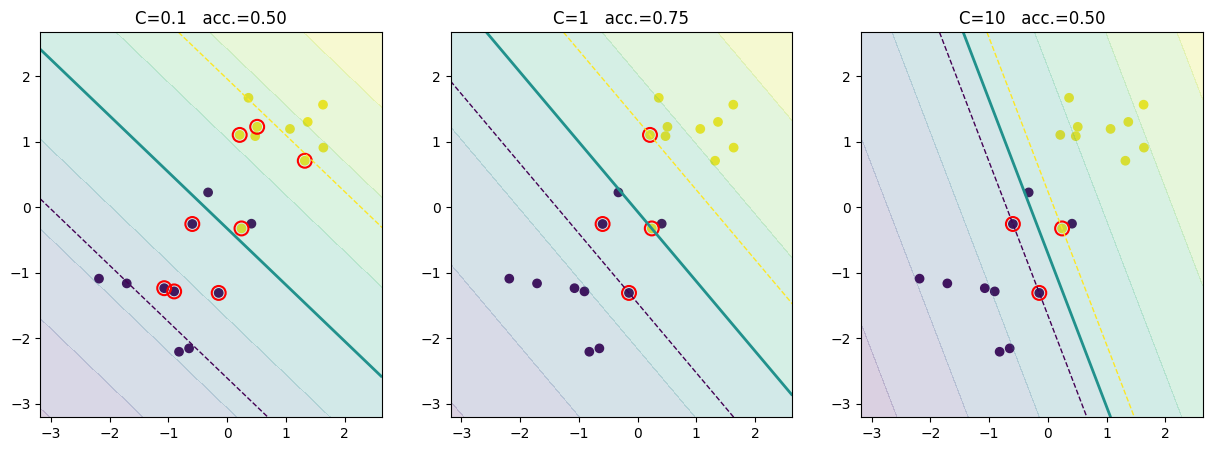

In [4]:

# Descomenta el dataset que quieras evaluar
X, y = create_dataset_linear(samples=20, std=[0.65,0.65])  # Dataset lineal
# X, y = create_dataset_moons(samples=150, noise=0.3)         # Dataset moons 
# X, y = create_dataset_poly([0.1,0,-7], samples=200, noise=0.4)  # Dataset polygon 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=23)

C = [0.1,1,10]
_, axes = plt.subplots(nrows=1, ncols=len(C), figsize=(15, 5))

for c,ax in zip(C,axes):
    # Crear y entrenar el modelo SVM
    model = SVC(kernel='linear', C=c, gamma='auto')
    scaler = StandardScaler()
    pipe = Pipeline([("scaler", scaler), ("svm", model)])
    acc = pipe.fit(X_train, y_train).score(X_test, y_test)

    # Mostrar puntos de datos
    ax.scatter(X[:, 0], X[:, 1], c=y)

    # Mostrar regiones de decisión
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    Z = pipe.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.2)

    # Mostrar márgenes y frontera de decisión
    ax.contour(xx, yy, Z, levels=[-1,0,1], linestyles=['--', '-', '--'], linewidths=[1,2,1])  # Línea de frontera y márgenes

    # Mostrar vectores soporte
    support_vectors = scaler.inverse_transform(model.support_vectors_)
    ax.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, facecolors='none', edgecolors='red', linewidths=1.5, label="Vectores de soporte")

    # Título
    ax.set_title(f'C={c}   acc.={acc:.2f}')
plt.show()

### Ejercicio 2. Parámetro de regularización C

El parámetro **C** representa cómo el modelo penaliza los errores en la clasificación de los datos de entrenamiento. Esto permite controlar el compromiso entre el ajuste del modelo y la generalización del mismo.

- Valores de C altos (C > 1) penaliza los errores de clasificación, con lo que el modelo intenta clasificar un mayor número de datos de entrenamiento correctamente. Tiene la ventaja de **minimizar los errores** en el conjunto de entrenamiento y la desventaja de tener un **mayor riesgo de sobreajuste**.

- Valores de C bajos (0< C < 1) da mayor tolerancia a errores de clasificación en los datos de entrenamiento, produciendo fronteras de decisión más sencillas. Esto **favorece la generalización**, pero conlleva un **mayor riesgo de subajuste**.

En este ejercicio vamos a crear un dataset de tipo `linear` con 150 observaciones, 10 características y `std=1` para la primera clase y `std=3` para la segunda. Esto creará una dataset con una frontera lineal, pero con bastante solapamiento entre los puntos de ambas clases (devido a la desviación estándar alta). Además tiene pocas observaciones, con lo que hay un mayor riesgo de sobreajuste.

El objetivo es encontrar el parámetro de regularización C óptimo para este dataset, utilizando para ello la técnica de **Grid Search**. Dado que vamos a usar con frecuencia la clase `GridSearchCV`, a continuación se da una función que muestra los resultados obtenidos con un objeto de este tipo. Puedes utilizar esta función en tus ejercicios para mostrar los resultados.

In [6]:
def show_results_gs(gs, sort=False):
    # Extraer los resultados del GridSearchCV
    results = gs.cv_results_

    # Crear un DataFrame con los parámetros y los resultados medios
    df_results = pd.DataFrame({
        'mean_test_score': results['mean_test_score'],
        'params': results['params']
    })

    # Ordenar los resultados por el resultado promedio (opcional)
    if sort:
        df_results = df_results.sort_values(by='mean_test_score', ascending=False)

    # Mostrar los resultados
    print(df_results)  

Escribe a continuación tu código:
- Encentra el parámetro de regularización C óptimo. 
- Muestra los resultados obtenidos con el conjunto de entrenamiento (usando la función `show_results_gs`
- Muestra el valor de C óptimo
- Muestra el resultado obtenido en el conjunto de test con el mejor clasificador

In [14]:
# Dataset lineal con 150 observaciones y 10 características
X, y = create_dataset_linear(samples=150, std=[1,3], n_features=10)  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=23)

# ESCRIBE AQUÍ TU SOLUCIÓN
model = SVC(kernel='linear', gamma='auto')
#pipe = Pipeline([("scaler", StandardScaler()), ("svm", model)])
params = {'C':[0.001, 0.01, 0.1, 1, 10, 100]}
gs = GridSearchCV(model, params, cv=5)
gs.fit(X_train, y_train)

print('RESULTADOS EN EL CONJUNTO DE ENTRENAMIENTO:')
show_results_gs(gs)
print('C ÓPTIMO: ', gs.best_params_)
print('RESULTADOS EN EL CONJUNTO DE TEST:', gs.score(X_test, y_test))

RESULTADOS EN EL CONJUNTO DE ENTRENAMIENTO:
   mean_test_score        params
0         0.825000  {'C': 0.001}
1         0.933333   {'C': 0.01}
2         0.925000    {'C': 0.1}
3         0.908333      {'C': 1}
4         0.891667     {'C': 10}
5         0.891667    {'C': 100}
C ÓPTIMO:  {'C': 0.01}
RESULTADOS EN EL CONJUNTO DE TEST: 0.9666666666666667


### Ejercicio 3. Parámetro gamma (kernel RBF)

Basándote en el código que se da en el ejercicio 1, realiza el siguiente experimento:

- Crea un dataset de tipo *moons* con 100 muestras y ruido=0.2
- Ajusta un clasificador SVC con kernel RBF, C=1 y valores de gamma = [0.1, 0.5, 1, 5]. Muestra gráficas similares a las del ejercicio 1
- Observa el efecto que tiene el parámetro gamma en la definición de la frontera de decisión

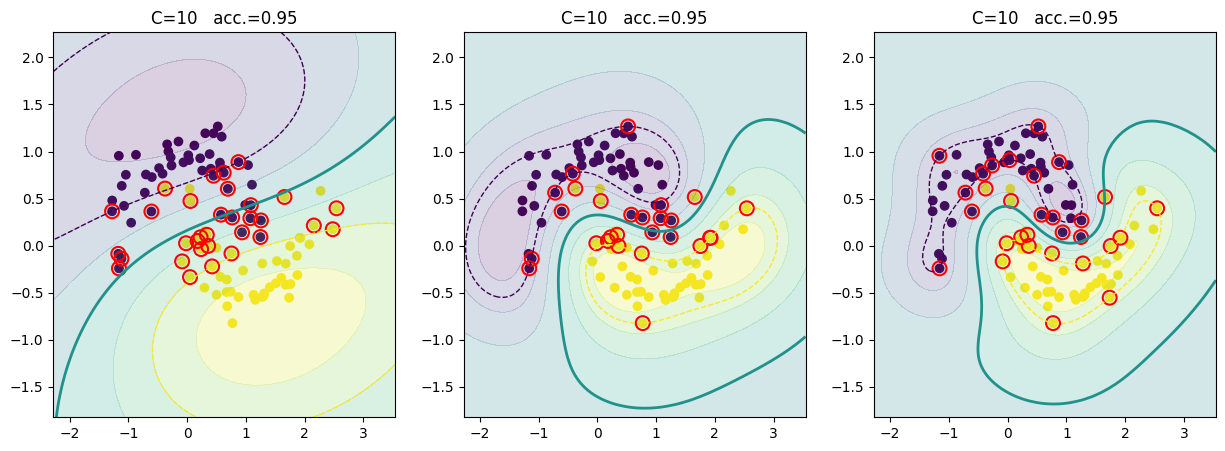

In [ ]:

X, y = create_dataset_moons(samples=100, noise=0.2)         # Dataset moons 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=23)

C=1
G=[0.1,0.5,1,5]
_, axes = plt.subplots(nrows=1, ncols=len(G), figsize=(15, 5))

for g,ax in zip(G,axes):
    # Crear y entrenar el modelo SVM
    model = SVC(kernel='rbf', C=C, gamma=g)
    scaler = StandardScaler()
    pipe = Pipeline([("scaler", scaler), ("svm", model)])
    acc = pipe.fit(X_train, y_train).score(X_test, y_test)

    # Mostrar puntos de datos
    ax.scatter(X[:, 0], X[:, 1], c=y)

    # Mostrar regiones de decisión
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    Z = pipe.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.2)

    # Mostrar márgenes y frontera de decisión
    ax.contour(xx, yy, Z, levels=[-1,0,1], linestyles=['--', '-', '--'], linewidths=[1,2,1])  # Línea de frontera y márgenes

    # Mostrar vectores soporte
    support_vectors = scaler.inverse_transform(model.support_vectors_)
    ax.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, facecolors='none', edgecolors='red', linewidths=1.5, label="Vectores de soporte")

    # Título
    ax.set_title(f'C={c}   acc.={acc:.2f}')
plt.show()